# Traffic simulation
In this exercise, using two datasets, I will be calculating and plotting two things:
1. The velocity of two vehicles based on their locations at specific points in time (+ max speed/ min speed)
2. The exact moment and between which vehicles a collision occurred based on their velocity at specific points in time
(+ locations of vehicles at specific points in time) <br>

Starting with the loading in of the two datasets:

In [1]:
import csv

def read_file(file_path):
    with open(file_path) as velocity_file:
        file_reader = csv.reader(velocity_file, delimiter=";")
        data = dict()
        time = list()
        for row in file_reader:
            for i in range(1, len(row)):
                data["Car {}".format(i)] = [float(row[i])]
            break
        for row in file_reader:
            time.append(float(row[0]))
            for i in range(1, len(row)):
                data["Car {}".format(i)].append(float(row[i]))
    return data, time


## 1. The speed of two vehicles:
The basic formula of velocity is as follows: <br>
$v_{avg} = \dfrac{\Delta x}{\Delta t}$ <br>
$v_{avg} = \dfrac{|x_{1} - x_{0}|}{t_{1}-t_{0}}$<br>
Meaning, velocity is the difference in space divided by the difference in time. <br>
In this dataset, the smallest difference in time you is 0.1 seconds. $\Delta t$ is thus always assumed as 0.1.
While usually you can achieve a negative velocity (going backwards) I have chosen for the purposes of this script to 
take the absolute difference in space. This ensures that velocity is always positive.

Car 1 max: 6.3500000000004775 min: 1.269999999999527
Car 2 max: 2.0000000000000284 min: 0.0


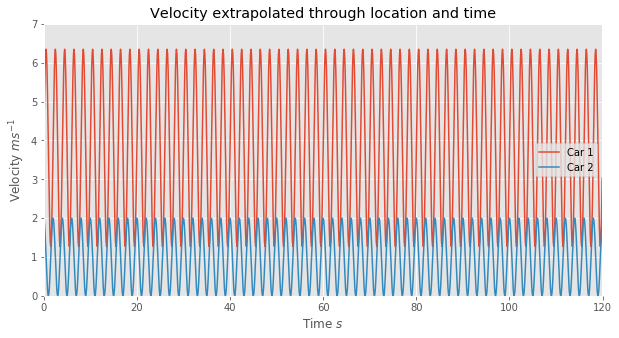

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
plt.rcParams['figure.figsize'] = [10,5]
style.use('ggplot')
def calculate_velocity():
    positions_calculated_velocities = dict()
    positions, time = read_file("verkeerssimulatie-rechteweg-posities.csv")

    for car in positions:
        positions_calculated_velocities[car] = {"list": list()}
        for location_index in range(1, len(positions[car])):
            # difference in location divided by difference in time
            positions_calculated_velocities[car]["list"].append(abs(positions[car][location_index] -
                                                                    positions[car][location_index - 1]) / 0.1)
        # Per car get max and min speed
        positions_calculated_velocities[car]["max"] = max(positions_calculated_velocities[car]["list"])
        positions_calculated_velocities[car]["min"] = min(positions_calculated_velocities[car]["list"])
        print(car, "max:",positions_calculated_velocities[car]["max"], "min:",positions_calculated_velocities[car]["min"])
        # Plot velocities per car
        plt.plot(time, positions_calculated_velocities[car]["list"], label=car)

    plt.axis([min(time), max(time), 0, 7])
    plt.legend()
    plt.title("Velocity extrapolated through location and time")
    plt.ylabel('Velocity $m s^{-1}$')
    plt.xlabel('Time $s$')
    plt.show()

calculate_velocity()

## The positions of three vehicles and when they collide
Location:<br>
$l_{current} \leftarrow$ current location, $s \leftarrow$ displacement in space <br>
$l_{current} = l_{previous}  + s$ <br>
$s = v t$ <br>
$l_{current} = l_{previous} + vt$ 
#### For example:
The location of car 1 at 0.1 seconds: <br>
$s = 0.38 \times 0.1 = 0.381 $m <br>
$l_{previous} = 0$ <br>
$l_{current} = 0 + 0.381 = 0.381$<br>

---

Below, these calculations are done for every 0.1 seconds in the dataset. <br>
You'll find two plots:
- Displacement over 120 seconds
- Displacement over 1 second. <br>
The reason for plotting the latter separately from the other is that the collision happen in that time frame.
It is, however, very hard to see over the full 120 seconds. 


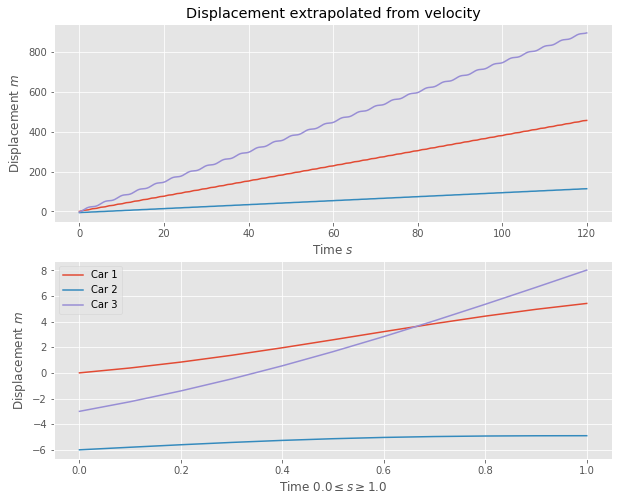

In [3]:
%matplotlib inline
def find_position():
    style.use('ggplot')
    plt.rcParams['figure.figsize'] = [10,8]
    velocities, time = read_file("verkeerssimulatie-rechteweg-snelheden.csv")
    positions = dict()
    
    for car in velocities:
        positions[car] = [velocities[car].pop(0)]
        for i in velocities[car][:-1]:
            # location = old location + velocity * time
            speed = i
            displacement = speed * 0.1
            location = positions[car][-1] + displacement
            positions[car].append(location)
    plt.figure(1)
    plt.subplot(211)
    for car in positions:
        plt.plot(time, positions[car], label=car)
    plt.title("Displacement extrapolated from velocity")
    plt.ylabel('Displacement $m$')
    plt.xlabel('Time $s$')
    plt.subplot(212)
    for car in positions:
        plt.plot(time[:11], positions[car][:11], label=car)
    plt.ylabel('Displacement $m$')
    plt.xlabel('Time $0.0 \leq s \geq 1.0$')
    plt.legend()
    plt.show()
    
    return positions, time
positions, time = find_position()

In latter plot, you can clearly see that somewhere between 0.6 and 0.8 that Car 1 and Car 2 intersect. The specific 
moment these two vehicles collide, is when the absolute distance between them is equal or smaller than 2 meters.


In [4]:
def find_collision(positions, time):
    collisions = dict()
    for car in positions:
        positions_minus_car = positions.copy()
        positions_minus_car.pop(car)
        # For all possible combinations of car (Car 1 + Car 2, Car 1 + Car 3, etc)
        for second_car in positions_minus_car:
            least_distance = abs(positions[car][0] - positions[second_car][0])
            for time_index in range(len(positions[car])):
                next_distance = abs(positions[car][time_index] - positions[second_car][time_index])
                # If distance between cars at current point is smaller than previously smallest distance
                if next_distance < least_distance:
                    # Set smallest distance to latest distance
                    least_distance = next_distance
                    # If the distance between cars is 2 meters or less, there's a collision.
                    if least_distance <= 2:
                        collisions[car + ";" + second_car] = time_index

    for collision in collisions:
        keys = collision.split(";")
        print(
    "A collision occurred between cars {} and {} at {} seconds".format(keys[0], keys[1],
                                                                       time[collisions[collision]])) 
find_collision(positions, time)


A collision occurred between cars Car 1 and Car 3 at 0.7 seconds
A collision occurred between cars Car 3 and Car 1 at 0.7 seconds
